# Exercise 2 - Part 2
## Q2: Implementing a regression model ignoring heterozygous markers, creating a Manhatten plot, and comparing to the original phenotype publication.
### - Chosen phenotype: ```Infectious disease, immune function: H5N1 influenza A virus mortality rate 30 days after infection (Boon-Webby Trait 1) [% death]```

####  Import libraries

In [119]:
import os
import pandas as pd
import numpy as np
from scipy.stats import f
import matplotlib.pyplot as plt

#### Running the regression model

In [120]:
def calc_pvalues(genotype_filename, phenotype_filename, phenotype_index):
    """Calculate p-values for the given phenotype index using linear regression ignoring heterozygous markers"""
    
    # Validate inputs
    if not os.path.isfile(genotype_filename):
        raise FileNotFoundError('Genotype file not found')
    if not os.path.isfile(phenotype_filename):
        raise FileNotFoundError('Phenotype file not found')

    # Read genotypes table
    gens_tbl = pd.read_excel(genotype_filename, skiprows=1, index_col=0, header=0)
    genes = gens_tbl.rename(columns={'Build37_position': 'position', 'Chr_Build37': 'chr', 'Locus': 'locus'})

    # Read phenotypes
    phno_tbl = pd.read_excel(phenotype_filename, index_col=0, header=0)
    pheno = phno_tbl.copy()
    # remove irrelevant columns
    pheno.drop(columns=['Phenotype', 'Authors', 'Year', 'Pubmed Id', 'C57BL/6J', 'DBA/2J'], inplace=True)   # parent's genotype is unspecified in the paper

    # Filter relevant data
    cur_pheno = pheno.loc[phenotype_index]    # select relevant phenotype data
    cur_pheno_strains = cur_pheno.dropna().index.tolist()  # remove strains with missing data for the phenotype
    cur_genes = genes[cur_pheno_strains].apply(lambda x: x.str.upper())  # filter genotypes for relevant strains
    cur_pheno = cur_pheno[cur_pheno_strains].values  # convert phenotype data to numpy array

    # Linear regression
    k = 2
    Xtotal = cur_genes.map(lambda x: 1 if x == 'D' else (0 if x == 'B' else np.nan)).values

    p_values = np.zeros(Xtotal.shape[0])

    for i in range(Xtotal.shape[0]):
        X = Xtotal[i, :]
        Y = cur_pheno
        valid_inds = ~np.isnan(X)
        X = X[valid_inds]
        Y = Y[valid_inds]
        n = len(Y)

        if n < k:
            continue

        Xav = np.mean(X)
        Yav = np.mean(Y)

        Sxx = np.sum(X**2) - n * Xav**2
        Sxy = np.sum(X * Y) - n * Xav * Yav

        b1 = Sxy / Sxx
        b0 = Yav - b1 * Xav
        Yhat = X * b1 + b0

        SST = np.sum((Y - Yav)**2)
        SSE = np.sum((Y - Yhat)**2)
        SSR = np.sum((Yhat - Yav)**2)

        MSR = SSR / (k-1)
        MSE = SSE / (n-k)

        F = MSR / MSE
        p_values[i] = 1 - f.cdf(F, k-1, n-k)

    # Write to excel
    results = pd.DataFrame({'Locus': genes['locus'],
                            'Chromosome': genes['chr'],
                            'Position': genes['position'],
                            'pValue_Negative_Log10': -np.log10(p_values)})
    results.to_csv('output/pval_results.csv', index=False)
    
    # Return p-values and relevant data
    all_data = {'all_genes': genes, 'all_pheno': pheno, 'cur_genes': cur_genes, 'cur_pheno': cur_pheno}
    return p_values, all_data

##### Run the model

In [121]:
# define run params
phenotype_idx = 787
genotypes_filename = 'data/genotypes.xls'
phenotypes_filename = 'data/phenotypes.xls'

# run the model
p_values, all_data = calc_pvalues(genotypes_filename, phenotypes_filename, phenotype_idx)

#### Create a Manhattan plot

There are a total of 3796 loci
There are at least 1928 recombination events



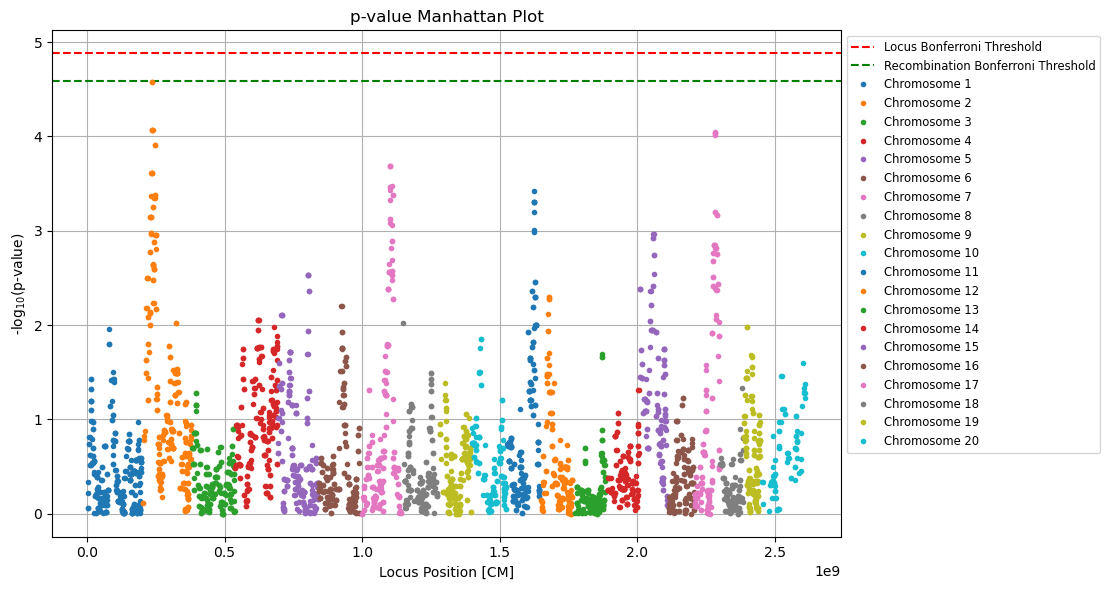

In [123]:
def prepare_genes_data(genes):
    """Add an 'abs_pos' column to the genes DataFrame."""
    pos = np.zeros(len(genes['position']))
    pos_diff = np.diff(genes['position'])
    pos[np.where(pos_diff < -1e6)[0] + 1] = genes['position'][np.where(pos_diff < -1e6)[0]]
    abs_pos = np.cumsum(pos) + genes['position']
    genes['abs_pos'] = abs_pos
    return genes

def plot_manhattan(genes, p_values, alpha=0.05):
    """Plot a Manhattan plot for the given genes and p-values, including Bonferroni correction."""
    
    # Number of loci
    num_loci = len(p_values)
    
    # Compute Bonferroni thresholds
    bonferroni_threshold_loci = alpha / num_loci
    num_of_recombination_region = np.sum(np.diff(p_values) != 0)
    bonferroni_threshold_recom = alpha / num_of_recombination_region
    print(f'There are a total of {num_loci} loci\n'
          f'There are at least {num_of_recombination_region} recombination events\n')

    # Prepare the genes DataFrame
    genes = prepare_genes_data(genes)

    # Set up figure
    plt.figure(figsize=(14, 6))
    plt.axhline(y=-np.log10(bonferroni_threshold_loci), color='r', linestyle='--', label='Locus Bonferroni Threshold')
    plt.axhline(y=-np.log10(bonferroni_threshold_recom), color='g', linestyle='--', label='Recombination Bonferroni Threshold')
    
    # Plot the data
    for chr_num in range(1, 21):
        chr_mask = genes['chr'] == chr_num
        plt.plot(genes['abs_pos'][chr_mask], -np.log10(p_values[chr_mask]), '.', label=f'Chromosome {chr_num}')
    
    # Add labels and legend
    plt.xlabel('Locus Position [CM]')
    plt.ylabel('-log$_{10}$(p-value)')
    plt.title('p-value Manhattan Plot')
    plt.grid(True)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
    plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust the layout to fit the legend outside
    
    # Save and show the plot
    plt.savefig('output/manhattan_plot.png')
    plt.show()
    

# Plot Manhattan plot
prepare_genes_data(all_data['all_genes'])
plot_manhattan(all_data['all_genes'], p_values, alpha=0.05)

##### Create Manhattan Plot for chromosome 2

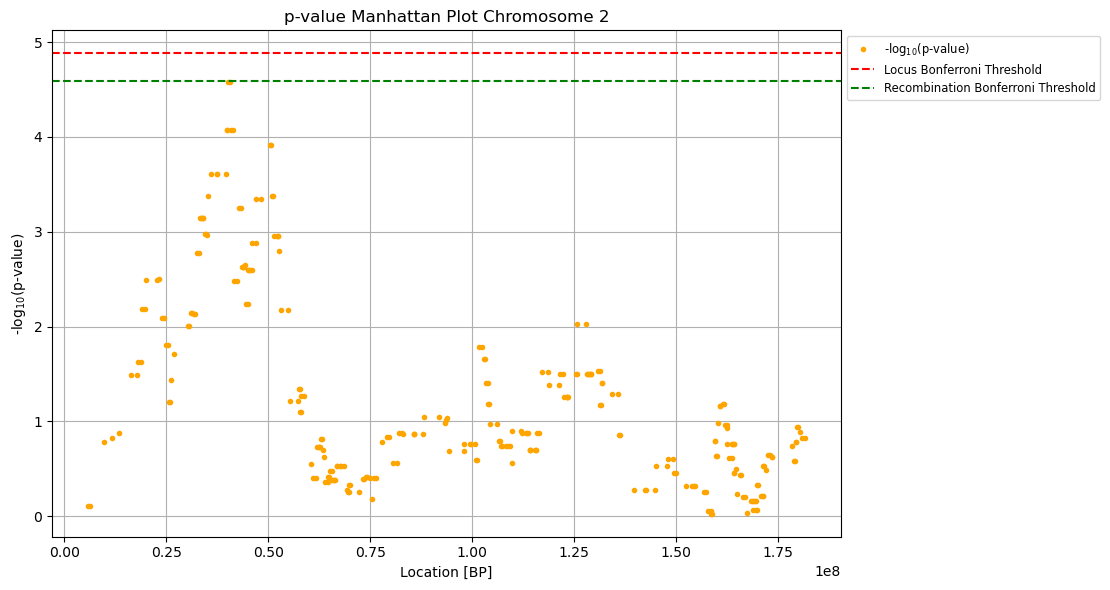

In [124]:
def plot_manhattan_chr19(genes, p_values, chromosome: int, alpha=0.05):
    """Plot a Manhattan plot for a specific Chromosome, including Bonferroni correction."""
    
    # Compute Bonferroni thresholds
    num_loci = len(p_values)
    bonferroni_threshold_loci = alpha / num_loci
    num_of_recombination_region = np.sum(np.diff(p_values) != 0)
    bonferroni_threshold_recom = alpha / num_of_recombination_region
    
    # Find p-values of the specific Chromosome only
    ch_mask = genes['chr'] == chromosome
    ch_p_values = p_values[ch_mask]
    
    # Find locations of Chromosome 19 only
    locs_ch = genes['position'][ch_mask]
    
    # Create Manhattan plot for Chromosome 19
    plt.figure(figsize=(14, 6))
    plt.plot(locs_ch, -np.log10(ch_p_values), '.', label='-log$_{10}$(p-value)', color='orange')
    plt.axhline(y=-np.log10(bonferroni_threshold_loci), color='r', linestyle='--', label='Locus Bonferroni Threshold')
    plt.axhline(y=-np.log10(bonferroni_threshold_recom), color='g', linestyle='--', label='Recombination Bonferroni Threshold')
    
    # Add labels and legend
    plt.xlabel('Location [BP]')
    plt.ylabel('-log$_{10}$(p-value)')
    plt.title(f'p-value Manhattan Plot Chromosome {str(chromosome)}')
    plt.grid(True)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
    plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust the layout to fit the legend outside
    
    # Save and show the plot
    plt.savefig(f'output/manhattan_plot_chr{str(chromosome)}.png')
    plt.show()
    
    
# Plot Manhattan plot for Chromosome 2
plot_manhattan_chr19(all_data['all_genes'], p_values, chromosome=2, alpha=0.05)